In [1]:
using OrdinaryDiffEq
using Optim, LsqFit
using Plots, LaTeXStrings
using DelimitedFiles
using DataFrames
using Statistics
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
function print_fit_values(fit, par0, par_names, alpha=0.1)
    println(@sprintf "RSS = %.5f (convergence: %s)" sum(abs2, fit.resid) fit.converged)
    for i in 1:length(par0)
        name = par_names[i]
        val = fit.param[i]
        CIl = confidence_interval(fit, alpha)[i][1]
        CIr = confidence_interval(fit, alpha)[i][2]
        p0 = par0[i]
        println(@sprintf "  %s = %.3e (CI=(%.3e, %.3e), initial=%.3e)" name val CIl CIr p0)
    end
end

print_fit_values (generic function with 2 methods)

# Viral load data fitting

Data for influenza from

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*


## Data set

10 mice with 13 data points each

In [4]:
tdata = [4.0/24, 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.]
data = readdlm("../../data/Smith2018/Virus_Best10.txt", ' ', Float64, '\n')
DataFrame(data, Symbol.(tdata))

,0.16666666666666666,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,4.18551,5.67816,6.00515,5.9364,5.97712,5.44716,5.19848,4.00515,0.0,0.0,0.0
2,0.0,3.99136,5.47712,5.84488,5.82436,5.81012,5.0874,4.49136,0.0,0.0,0.0,0.0
3,0.0,3.49136,5.44716,5.81012,5.83815,5.78016,5.2954,5.01851,2.94716,0.0,0.0,0.0
4,0.0,3.29788,5.77233,6.24612,5.49136,5.9624,5.14412,5.51851,3.23882,0.0,0.0,0.0
5,0.0,4.75515,5.9624,6.44716,5.78016,5.83244,5.99136,4.96982,0.0,0.0,0.0,0.0
6,0.0,4.30151,5.49136,6.86448,5.70812,5.80282,4.9624,4.47712,0.0,0.0,0.0,0.0
7,0.0,3.49136,5.7954,5.74951,6.03148,5.82436,5.2954,5.17215,3.26036,0.0,0.0,0.0
8,0.0,4.00515,6.03148,5.83815,6.26036,6.1294,5.18551,4.83815,0.0,0.0,0.0,0.0
9,0.0,3.49136,6.18551,5.78784,5.59921,5.97712,5.34488,5.47712,0.0,0.0,0.0,0.0


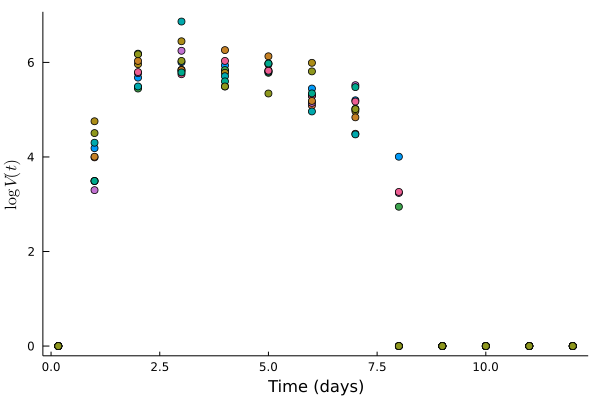

In [5]:
plt = plot(legend=:none, grid=:none, xlabel="Time (days)", ylabel=L"\log\,V(t)")
[plot!(tdata, data[i, :], seriestype=:scatter) for i in 1:size(data, 1)]
plt

### Combined data

In [6]:
ttdata = repeat(tdata, inner=10)
tend = ttdata[end]
vvdata = reshape(data, 1, :)[:];

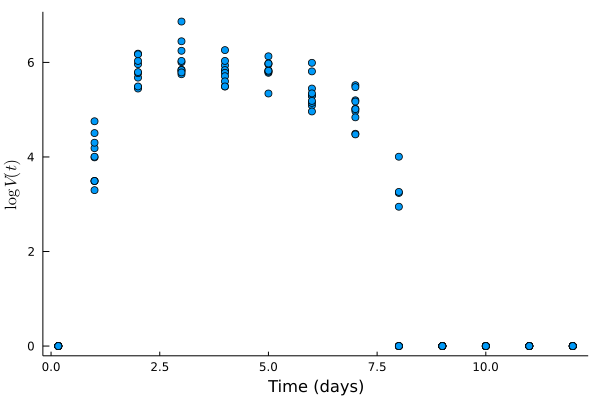

In [7]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

## Fitting the ODE Model to data


The standard viral kinetic model with varying clearance rate reads
$$
\begin{aligned}
\frac{dT}{dt} & = -\beta T V, \\
\frac{dI_1}{dt} & = \beta T V - k I_1, \\
\frac{dI_2}{dt} & = k I_1 - \frac{\delta I_2}{K + I_2}, \\
\frac{dV}{dt} & = p I_2 -c V.
\end{aligned}
$$

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*

In order to fit to data, we use the same idea as in the empirical virus load function. That is we compare data with
$$
\min (\log V, \theta)
$$
where $V$ is the solution of the ODE system, and $\theta$ is the threshold defined by data set.

In [8]:
function ViralTargetODE!(du, u, p, t)
    T, I₁, I₂, V = u
    β, k, δ, K, p, c = p
    du[1] = dT = -β*T*V
    du[2] = dI₁ = β*T*V - k*I₁
    du[3] = dI₂ = k*I₁ - δ*I₂/(K + I₂)
    du[4] = dV = p*I₂ - c*V
end
u0 = [1e+7, 75.0, 0.0, 1e-12]
θ = minimum(vvdata)
pars = (β = 9.9e-05,
        k = 4.0e+00,
        δ = 1.65e+06,
        K = 1.13400e+05,
        p = 1.7e+00,
        c = 1.248e+01)
par_names = keys(pars)
function LogViralTargetModel(t, p)
    tspan = (0.0, tend)
    pars = (β = p[1],
            k = p[2],
            δ = p[3],
            K = p[4],
            p = p[5],
            c = p[6])
    prob = ODEProblem(ViralTargetODE!, u0, tspan, values(pars))
    sol = solve(prob, Tsit5(), dtmax=1e-2)
    max.(log10.(sol(t)[end, :]), θ)
end

LogViralTargetModel (generic function with 1 method)

In [9]:
par0 = [9.9e-5,
        4.0,
        1.65e+6,
        113400,
        1.7,
        12.48]
# lb = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# ub = [Inf, Inf, Inf, Inf, Inf, Inf]
lb = [1e-6, 1.0, 1e4, 1e2, 1e-1, 1e0]
ub = [1e-1, 6.0, 4e6, 1e6, 1e+3, 1e3]
fit = curve_fit(LogViralTargetModel, ttdata, vvdata, par0, lower=lb, upper=ub)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([0.00028227928546437493, 1.488217826008505, 1.5964417489269038e6, 85007.46438168186, 2.2618691386674286, 16.353594235055017], [0.000474602250437993, 0.000474602250437993, 0.000474602250437993, 0.000474602250437993, 0.000474602250437993, 0.000474602250437993, 0.000474602250437993, 0.000474602250437993, 0.000474602250437993, 0.000474602250437993  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [408.8044564096104 0.39869411127323495 … 0.2845154782317962 -0.01998107613207046; 408.8044564096104 0.39869411127323495 … 0.2845154782317962 -0.01998107613207046; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], true, Float64[])

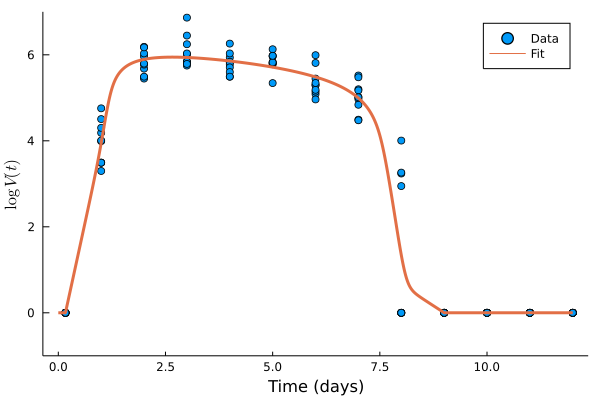

In [10]:
pt = plot(ttdata, vvdata, seriestype=:scatter, label="Data")
tt = [range(0., tend, step=1e-2);]
plot!(pt, tt, LogViralTargetModel(tt, fit.param), lw=3, 
    label="Fit", grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
savefig(figdir*"Smith2018ODEDataFit.png")
savefig(figdir*"Smith2018ODEDataFit.pdf")
display(pt)

In [11]:
print_fit_values(fit, par0, par_names, 0.05)

RSS = 35.40170 (convergence: true)
  β = 2.823e-04 (CI=(7.735e-05, 4.872e-04), initial=9.900e-05)
  k = 1.488e+00 (CI=(1.312e+00, 1.664e+00), initial=4.000e+00)
  δ = 1.596e+06 (CI=(1.414e+06, 1.779e+06), initial=1.650e+06)
  K = 8.501e+04 (CI=(5.442e+03, 1.646e+05), initial=1.134e+05)
  p = 2.262e+00 (CI=(-4.860e-01, 5.010e+00), initial=1.700e+00)
  c = 1.635e+01 (CI=(-7.205e+00, 3.991e+01), initial=1.248e+01)


Standard errors are really high, although the convergence was true.